In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [3]:
sns.set()
# sns.set(style="darkgrid")

In [4]:
data_path = 'D:\DATA\PracticeData'
data_type = {'code': 'object', 'nutrition_grade_fr': 'category'}

df = pd.read_csv(os.path.join(data_path, 'openfoodfacts_processed.gz'), \
                 dtype=data_type, compression='gzip')
df.shape

(559935, 25)

In [5]:
df.columns.values

array(['code', 'product_name', 'labels_tags', 'countries_tags',
       'categories_tags', 'additives_n', 'additives_tags', 'energy_100g',
       'fat_100g', 'fiber_100g', 'proteins_100g', 'sugars_100g',
       'sodium_100g', 'salt_100g', 'alcohol_100g', 'caffeine_100g',
       'cocoa_100g', 'energy-from-fat_100g', 'saturated-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_fr'], dtype=object)

In [6]:
# for having grades
df2 = df[df.nutrition_grade_fr.notna()]
df2.reset_index(inplace=True, drop=True)
df2.shape

(146356, 25)

In [7]:
# get the index with a string in the cell of a column
def get_category(string, column, dataframe): 
    idx_list = []
    for idx, row in dataframe.iterrows():
        if row[column] is not np.nan and string in row[column]:
            idx_list.append(idx)
    return idx_list

## Are Sugary Snacks always unhealthy? What is the healthiest in this category?
Sub-categories:   
Bars, Biscuits and cakes, Chocolates, Confectioneries, Popcorn, Viennoiseries

In [7]:
sugary_snacks = get_category('en:sugary-snacks', 'categories_tags', df2)

In [8]:
df_ss = df2.iloc[sugary_snacks, :]

In [9]:
df_ss = df_ss[['code', 'categories_tags', 'energy_100g', 'fat_100g', 'fiber_100g', \
       'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'cocoa_100g', \
       'nutrition_grade_fr', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]
df_ss.reset_index(inplace=True, drop=True)
df_ss.shape

(24809, 13)

In [10]:
ss_sub = set(['en:bars', 'en:biscuits-and-cakes', 'en:chocolates', \
          'en:confectioneries', 'en:popcorn', 'en:viennoiseries'])

In [11]:
def create_sub(row):
    cats = list(ss_sub.intersection(set(row.split(','))))
    if len(cats) != 0: return cats[0]
    else: return np.nan

In [12]:
df_ss['sub_category'] = df_ss.categories_tags.apply(create_sub)
df_ss.sub_category = df_ss.sub_category.astype('category')
df_ss = df_ss.drop('categories_tags', axis=1)

In [13]:
# drop rows that have NaN for: sub_category, energy_100g, fat_100g
df_ss = df_ss[df_ss.sub_category.notnull() & df_ss.energy_100g.notnull() & df_ss.fat_100g.notnull()]
# fill NaN in fiber_100g with 0, i.e. this sweet has no fiber content
df_ss.fiber_100g = df_ss.fiber_100g.fillna(0)

In [14]:
tmp = df_ss[['code', 'sub_category', 'nutrition_grade_fr']].groupby(by=['sub_category', 'nutrition_grade_fr']).count()
tmp['percentage'] = None

In [15]:
for idx in tmp.index.levels[0].values: 
    tmp.loc[idx, 'percentage'] = (tmp.loc[idx, 'code'] / sum(tmp.loc[idx, 'code'])).values * 100

In [16]:
total = tmp.loc[pd.IndexSlice[:, :], 'code'].values.sum()
sugary_all = []
for idx2 in tmp.index.levels[1].values:
    sugary_all.append(tmp.loc[pd.IndexSlice[:, idx2], 'code'].values.sum() / total  * 100)

In [17]:
sugary_all = pd.Series(data=sugary_all, index =['a', 'b', 'c', 'd', 'e'])
# sugary_all

In [18]:
tmp.drop('code', axis=1).unstack()

percentage                                      
nutrition_grade_fr             a         b         c        d        e
sub_category                                                          
en:bars                  1.39958   1.60952   17.7047  32.6802   46.606
en:biscuits-and-cakes    0.55591  0.792855    6.1788  36.3164   56.156
en:chocolates          0.0711997  0.729797  0.907796  13.6169  84.6743
en:confectioneries      0.726232   7.96655    8.4287  47.6012  35.2773
en:popcorn               4.07407   1.11111   15.9259  55.1852  23.7037
en:viennoiseries         0.18622  0.310366   5.40037   55.121   38.982

#### Cocoa content of chocolatese in each rank

In [19]:
df_cc = df_ss[(df_ss.cocoa_100g.notnull()) & (df_ss.sub_category == 'en:chocolates')]
df_cc.head()

,code,energy_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,cocoa_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,sub_category
50,00071185,517,29.3,0.0,6.1,0.18,0.070866,56.1,30.0,e,26.0,26.0,en:chocolates
67,00101530,583,45.1,0.0,10.3,0.01,0.003937,24.0,78.0,e,22.0,22.0,en:chocolates
68,00101639,569,40.4,9.9,8.4,0.10,0.039370,31.8,71.0,e,19.0,19.0,en:chocolates
104,00119740,268,6.6,1.5,6.7,0.78,0.307087,23.4,24.0,e,22.0,10.0,en:chocolates
106,00123051,597,46.7,0.0,9.3,0.01,0.003937,25.2,75.0,e,22.0,22.0,en:chocolates


## What are the percentage of cocoa content in all chocolates? What's their calorie count? 
Does higher cocoa chocolate has less calorie? Or less sugar? 
1. from the dataframe df_ss, get data having cocoa and is of chocoloates sub-category
2. plot the cocoa content by histogram and density distribution
3. fit a regression model, to predict the cocoa content of a chocolate
    + try to fit with the major contents: energy, fat, sugar, fiber, protein, salt
    + try different algorithm, or use more features
    + https://stackoverflow.com/questions/47577168/how-can-i-increase-the-accuracy-of-my-linear-regression-modelmachine-learning

In [20]:
df_cc = df_ss[(df_ss.cocoa_100g.notnull()) & (df_ss.sub_category == 'en:chocolates')]

In [21]:
df_cc.head()

,code,energy_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,cocoa_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,sub_category
50,00071185,517,29.3,0.0,6.1,0.18,0.070866,56.1,30.0,e,26.0,26.0,en:chocolates
67,00101530,583,45.1,0.0,10.3,0.01,0.003937,24.0,78.0,e,22.0,22.0,en:chocolates
68,00101639,569,40.4,9.9,8.4,0.10,0.039370,31.8,71.0,e,19.0,19.0,en:chocolates
104,00119740,268,6.6,1.5,6.7,0.78,0.307087,23.4,24.0,e,22.0,10.0,en:chocolates
106,00123051,597,46.7,0.0,9.3,0.01,0.003937,25.2,75.0,e,22.0,22.0,en:chocolates


C:\Users\davilaYuan\Miniconda3\envs\sklearn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


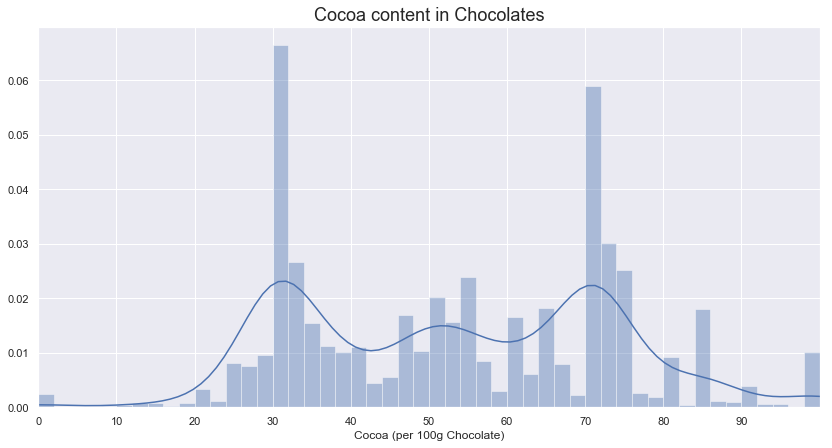

In [22]:
plt.figure(figsize=(14, 7))
sns.distplot(df_cc.cocoa_100g, bins=50, kde=True)
plt.xlim(0, 100); plt.xticks(range(0, 100, 10))
plt.grid(True)
plt.title('Cocoa content in Chocolates', fontdict={'fontsize': 18})
plt.xlabel('Cocoa (per 100g Chocolate)')
# plt.savefig('cocoa.png', bbox_inches='tight', dpi=300)

plt.show()
# looks like bimodal, primary at 30% or 70%

## Additives of Ice Creams
does ice cream flavor correlates with its calorie? energie? cannot do that, since flavor is not recorded clearly

In [23]:
frozen = get_category('en:frozen-foods', 'categories_tags', df2)

In [24]:
df_ff = df2.iloc[frozen, :]
df_ff.reset_index(inplace=True, drop=True)

In [25]:
ice_sor = get_category('en:ice-creams-and-sorbets', 'categories_tags', df_ff)

In [26]:
df_ice = df_ff.iloc[ice_sor, :]
df_ice.reset_index(inplace=True, drop=True)

In [27]:
df_ice = df_ice[['code','energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', \
               'sodium_100g', 'sugars_100g', 'additives_n', 'additives_tags', 'labels_tags', \
               'nutrition_grade_fr']]

In [28]:
df_ice.head()

,code,energy_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,additives_n,additives_tags,labels_tags,nutrition_grade_fr
0,0011110017734,284,10.81,1.4,4.05,0.51562,0.203,21.62,7.0,"en:e407,en:e410,en:e412,en:e433,en:e466,en:e47...",NaN,d
1,0011110022950,286,9.52,1.6,4.76,0.56388,0.222,22.22,9.0,"en:e102,en:e133,en:e407,en:e410,en:e412,en:e43...",NaN,d
2,0011110576606,270,9.52,1.6,4.76,0.60452,0.238,20.63,7.0,"en:e407,en:e410,en:e412,en:e433,en:e466,en:e47...",NaN,d
3,0011110578693,266,9.38,1.6,4.69,0.59436,0.234,21.88,6.0,"en:e407,en:e410,en:e412,en:e433,en:e466,en:e471",NaN,d
4,0011150589031,267,8.33,0.0,5.00,0.57150,0.225,21.67,8.0,"en:e150a,en:e160b,en:e322,en:e322i,en:e407,en:...",NaN,d


## Are food high in fiber healthy?
+ correlation between fiber content and score/category
+ modeling with just fiber content? 

In [8]:
df_hm = df2[df2.fiber_100g.notna() & df2['nutrition-score-fr_100g']]
df_hm.reset_index(inplace=True, drop=True)

In [9]:
df_hm = df_hm[['energy_100g', 'fat_100g','proteins_100g', 'salt_100g', 'fiber_100g',  \
               'sodium_100g', 'sugars_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr']]

In [10]:
tmp = df_hm[['energy_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',  'fiber_100g', 'nutrition_grade_fr']]
tmp.shape

(72611, 6)

In [11]:
pd.get_dummies(tmp).corr().head()

,energy_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,nutrition_grade_fr_a,nutrition_grade_fr_b,nutrition_grade_fr_c,nutrition_grade_fr_d,nutrition_grade_fr_e
energy_100g,1.000000,0.283890,0.259880,-0.045370,0.222466,-0.230561,-0.233399,-0.103652,0.270051,0.234978
sugars_100g,0.283890,1.000000,-0.200878,-0.077850,0.020362,-0.266340,-0.143319,-0.062679,0.134680,0.310627
proteins_100g,0.259880,-0.200878,1.000000,0.038962,0.231974,0.066943,-0.067079,-0.031809,0.086044,-0.080688
salt_100g,-0.045370,-0.077850,0.038962,1.000000,-0.014551,-0.082251,-0.033162,0.071801,0.043566,-0.014095
fiber_100g,0.222466,0.020362,0.231974,-0.014551,1.000000,0.211685,-0.076867,0.001530,-0.055292,-0.100833


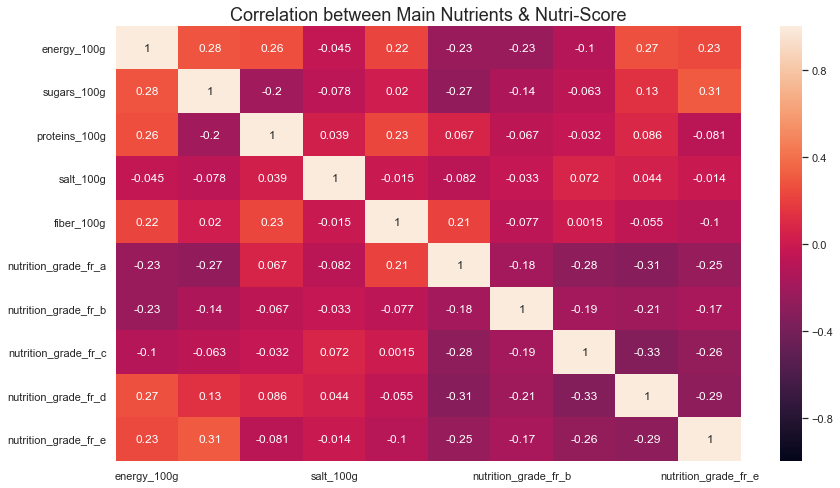

In [12]:
# take value with less than 500 energy
plt.figure(figsize=(14, 8))
sns.heatmap(pd.get_dummies(tmp).corr(), xticklabels=3,  annot=True, vmin=-1.0, vmax=1.0)
plt.title('Correlation between Main Nutrients & Nutri-Score', fontdict={'fontsize': 18})
# plt.savefig('fig06_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

## Report the correlation between nutrients

In [34]:
df_corr = df2[['energy_100g', 'fat_100g', 'sugars_100g', 'proteins_100g', \
               'salt_100g', 'sodium_100g', 'fiber_100g', ]]

In [35]:
df_corr.describe()

,energy_100g,fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g
count,146356.000000,146356.000000,146356.000000,146356.000000,146356.000000,146356.000000,76901.000000
mean,268.940433,14.295713,13.516588,7.334595,1.085180,0.427234,2.736315
std,198.617614,18.774106,18.818759,7.883725,4.503782,1.773114,4.479292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95.000000,0.900000,1.000000,1.200000,0.050000,0.019685,0.010000
50%,245.000000,6.900000,4.400000,5.500000,0.410000,0.161417,1.500000
75%,400.000000,22.000000,19.000000,10.000000,1.200000,0.472441,3.500000
max,2385.000000,100.000000,100.000000,100.000000,100.000000,39.400000,100.000000


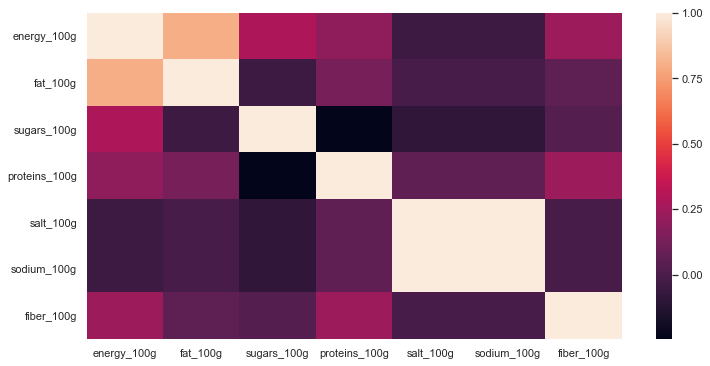

In [36]:
plt.figure(figsize=(12, 6))
# sns.heatmap(tmp.corr())
sns.heatmap(df_corr.corr())
plt.show()

## Are products with 'organic' labels necessary healthy?
+ in labels_tags, search for en:organic or en:eu-organic
+ more like organic is always associated with fresh foods, therefore less processed
+ do organic foods has additives?

In [13]:
df_org = df2[df2.labels_tags.notna()]
df_org.reset_index(inplace=True, drop=True)
df_org.shape

(68789, 25)

In [14]:
org1 = get_category('en:organic', 'labels_tags', df_org)

In [15]:
org2 = get_category('en:eu-organic', 'labels_tags', df_org)

In [16]:
org = list(set(org1).union(set(org2)))
len(org)

19505

In [17]:
df_org = df_org.iloc[org, :][['additives_n', 'energy_100g', \
                              'proteins_100g', 'salt_100g', 'fiber_100g', \
                              'sugars_100g','nutrition_grade_fr']]

In [18]:
df_org.additives_n = df_org.additives_n.fillna(0)
df_org.fiber_100g = df_org.fiber_100g.fillna(0)

In [19]:
df_org = df_org[df_org.sugars_100g.notna()]

In [20]:
tmp = df2[['additives_n', 'energy_100g', 'proteins_100g', 'salt_100g', \
           'fiber_100g', 'sugars_100g']]
tmp = tmp[tmp.additives_n.notna()]
tmp.fiber_100g.fillna(0, inplace=True)

In [21]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122042 entries, 3 to 146354
Data columns (total 6 columns):
additives_n      122042 non-null float64
energy_100g      122042 non-null int64
proteins_100g    122042 non-null float64
salt_100g        122042 non-null float64
fiber_100g       122042 non-null float64
sugars_100g      122042 non-null float64
dtypes: float64(5), int64(1)
memory usage: 6.5 MB


In [22]:
temp = df_org.copy()
temp.drop('nutrition_grade_fr', axis=1, inplace=True)
temp.reset_index(inplace=True, drop=True)
temp['kind'] = 'organic'
print(temp.shape)
temp.head()

(19505, 7)


,additives_n,energy_100g,proteins_100g,salt_100g,fiber_100g,sugars_100g,kind
0,1.0,16,0.7,1.016,0.7,2.40,organic
1,0.0,43,0.1,0.000,0.1,10.40,organic
2,0.0,378,8.0,0.480,4.8,3.15,organic
3,1.0,178,0.9,0.000,0.6,38.70,organic
4,2.0,181,0.9,0.000,0.6,38.70,organic


In [23]:
temp_all = tmp.copy()
temp_all.reset_index(inplace=True, drop=True)
temp_all['kind'] = 'overall'
print(temp_all.shape)
temp_all.head()

(122042, 7)


,additives_n,energy_100g,proteins_100g,salt_100g,fiber_100g,sugars_100g,kind
0,3.0,160,9.50,0.358,1.6,0.6,overall
1,2.0,108,6.80,0.700,0.5,0.5,overall
2,3.0,289,22.00,2.160,2.0,0.0,overall
3,4.0,467,6.80,0.500,0.1,69.8,overall
4,3.0,261,3.33,0.647,2.0,24.7,overall


In [24]:
melted = pd.concat([temp, temp_all])
melted.kind = melted.kind.astype('category')
melted.shape

(141547, 7)

In [25]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141547 entries, 0 to 122041
Data columns (total 7 columns):
additives_n      141547 non-null float64
energy_100g      141547 non-null int64
proteins_100g    141547 non-null float64
salt_100g        141547 non-null float64
fiber_100g       141547 non-null float64
sugars_100g      141547 non-null float64
kind             141547 non-null category
dtypes: category(1), float64(5), int64(1)
memory usage: 7.7 MB


In [26]:
plot_cols = ['additives_n', 'energy_100g', 'proteins_100g', 'salt_100g', 'fiber_100g', 'sugars_100g']

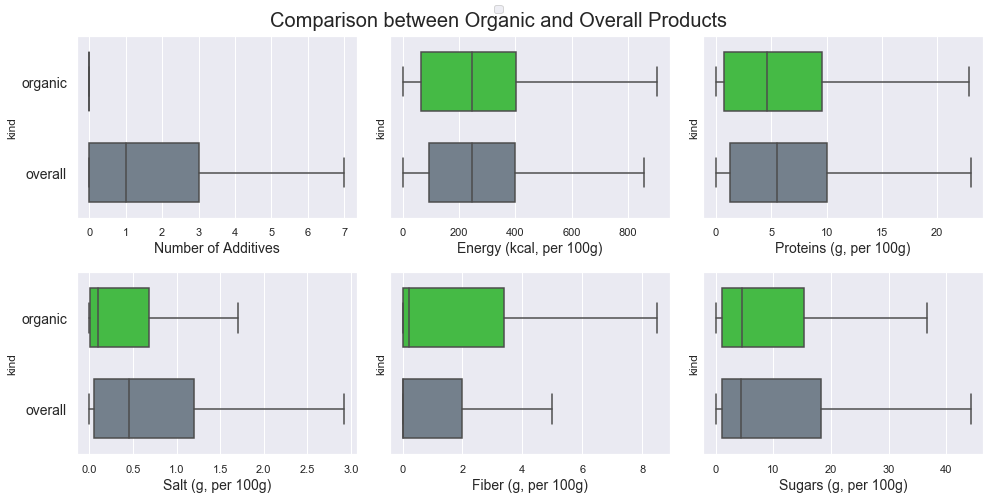

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7), sharey=True)

sns.boxplot(y='kind',x='additives_n', data=melted, showfliers=False, \
            ax=axes[0, 0], palette=['limegreen', 'slategrey'], width=0.65)
axes[0, 0].set_xlabel('Number of Additives', fontdict={'fontsize': 14})
# axes[0, 0].set_yticks(['Organic', 'Overall']) 
# print(axes[0, 0].set_yticklabels(['Organic', 'Overall']))
axes[0, 0].set_yticklabels(['Organic', 'Overall'], fontsize=14)

sns.boxplot(y='kind',x='energy_100g', data=melted, showfliers=False, \
            ax=axes[0, 1], palette=['limegreen', 'slategrey'], width=0.65)
axes[0, 1].set_xlabel('Energy (kcal, per 100g)', fontdict={'fontsize': 14})

sns.boxplot(y='kind',x='proteins_100g', data=melted, showfliers=False, \
            ax=axes[0, 2], palette=['limegreen', 'slategrey'], width=0.65)
axes[0, 2].set_xlabel('Proteins (g, per 100g)', fontdict={'fontsize': 14})

sns.boxplot(y='kind',x='salt_100g', data=melted, showfliers=False, \
            ax=axes[1, 0], palette=['limegreen', 'slategrey'], width=0.65)
axes[1, 0].set_xlabel('Salt (g, per 100g)', fontdict={'fontsize': 14})
axes[1, 0].set_yticklabels(['Organic', 'Overall'], fontsize=14)

sns.boxplot(y='kind',x='fiber_100g', data=melted, showfliers=False, \
            ax=axes[1, 1], palette=['limegreen', 'slategrey'], width=0.65)
axes[1, 1].set_xlabel('Fiber (g, per 100g)', fontdict={'fontsize': 14})

sns.boxplot(y='kind',x='sugars_100g', data=melted, showfliers=False, \
            ax=axes[1, 2], palette=['limegreen', 'slategrey'], width=0.65)
axes[1, 2].set_xlabel('Sugars (g, per 100g)', fontdict={'fontsize': 14})

fig.suptitle('Comparison between Organic and Overall Products', fontsize=20) 
# plt.legend(loc='best', fontsize=14)
fig.tight_layout() #plt.tight_layout()
fig.subplots_adjust(top=0.93)

handles, labels = axes[1, 2].get_legend_handles_labels()
# fig.legend(['Organic', 'Overall'])
fig.legend(handles, labels, loc='upper center')

# plt.savefig('fig09_organic2.png', bbox_inches='tight', dpi=300)

plt.show()

In [28]:
tmp = df2[['code', 'nutrition_grade_fr']].groupby(by='nutrition_grade_fr').count().reset_index()
tmp['overall'] = tmp.code.apply(lambda x: x / tmp.code.sum())
# tmp

tmp2 = df_org[['additives_n', 'nutrition_grade_fr']].groupby(by='nutrition_grade_fr').count().reset_index()
tmp2['organic'] = tmp2.additives_n.apply(lambda x: x / tmp2.additives_n.sum())
# tmp2

In [29]:
df = pd.merge(tmp.drop('code', axis=1), tmp2.drop('additives_n', axis=1))
tmp = pd.melt(df, id_vars='nutrition_grade_fr', var_name='category', value_name='rank_percentage')

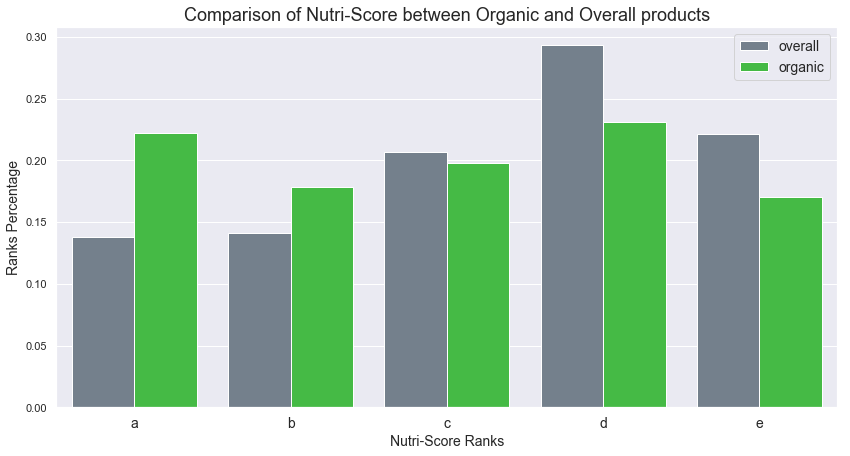

In [31]:
plt.figure(figsize=(14, 7))
sns.barplot(x="nutrition_grade_fr", y="rank_percentage", hue="category", data=tmp, palette=['slategrey', 'limegreen'])
plt.xlabel('Nutri-Score Ranks', fontdict={'fontsize': 14})
plt.ylabel('Ranks Percentage', fontdict={'fontsize': 14})
plt.xticks(fontsize=14)
plt.title('Comparison of Nutri-Score between Organic and Overall products', fontdict={'fontsize': 18})
plt.legend(loc='best', fontsize=14)
# plt.savefig('fig08_organic1.png', bbox_inches='tight', dpi=300)
plt.show()